In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Data Acquistion

In [2]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'

In [3]:
df = pd.read_csv(url)
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


### Data Preparation 

In [4]:
features = [
    'Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
    'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP'
]

df = df[features].copy()

df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)

mean_price = df.msrp.mean()
df['above_average'] = (df.msrp >= mean_price).astype(int)

del df['msrp']

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [7]:
def above_average(val):
    if val > mean:
        return 1
    else:
        return 0

### Question 1: ROC AUC feature importance
###### ROC AUC could also be used to evaluate feature importance of numerical variables.

###### Let's do that

###### For each numerical variable, use it as score and compute AUC with the above_average variable
###### Use the training dataset for that
###### If your AUC is < 0.5, invert this variable by putting "-" in front

###### (e.g. -df_train['engine_hp'])

###### AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve

In [9]:
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%16s, %.3f' % (c, auc))

            year, 0.688
       engine_hp, 0.917
engine_cylinders, 0.766
     highway_mpg, 0.633
        city_mpg, 0.673


### Answer: engine_hp

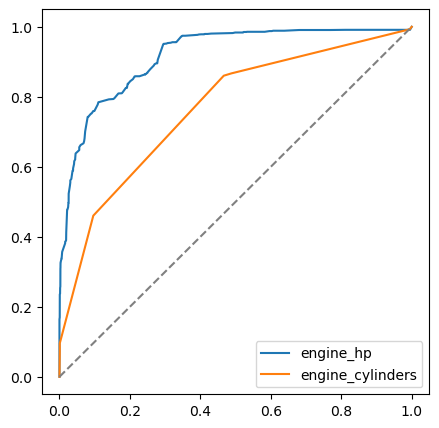

In [10]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.engine_hp)
plt.plot(fpr, tpr, label='engine_hp')

fpr, tpr, _ = roc_curve(y_train, df_train.engine_cylinders)
plt.plot(fpr, tpr, label='engine_cylinders')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

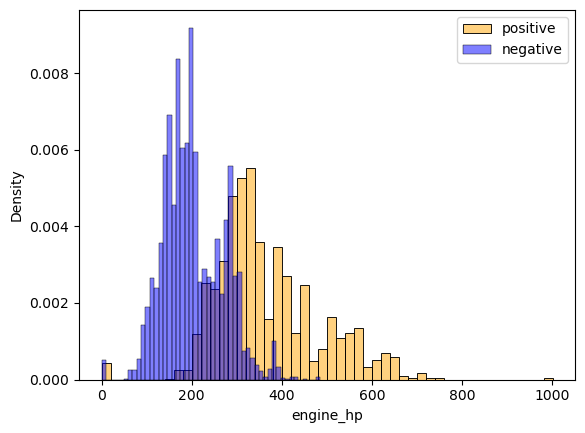

In [11]:
sns.histplot(df_train.engine_hp[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(df_train.engine_hp[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

### Question 2: Training the model
###### Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:
###### LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [12]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [13]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [14]:
roc_auc_score(y_val, y_pred)

0.9796438874179095

### Question 3: Precision and Recall
###### Now let's compute precision and recall for our model.
###### Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
###### For each threshold, compute precision and recall
###### Plot them

In [15]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

In [16]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

In [17]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,644,330,10,1399
20,0.2,623,201,31,1528
30,0.3,607,138,47,1591
40,0.4,593,104,61,1625
50,0.5,570,69,84,1660
60,0.6,550,50,104,1679
70,0.7,509,26,145,1703
80,0.8,468,15,186,1714
90,0.9,377,3,277,1726


In [18]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

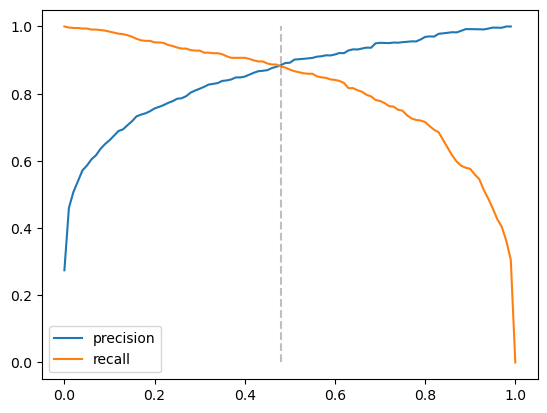

In [19]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.48, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

#### Ans: 0.48

### Question 4: F1 score
###### Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both
 
###### Where 
 ###### is precision and 
 ###### is recall.

###### Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [20]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [21]:
df_scores.loc[df_scores.f1.argmax()]

threshold       0.490000
tp            574.000000
fp             70.000000
fn             80.000000
tn           1659.000000
p               0.891304
r               0.877676
f1              0.884438
Name: 49, dtype: float64

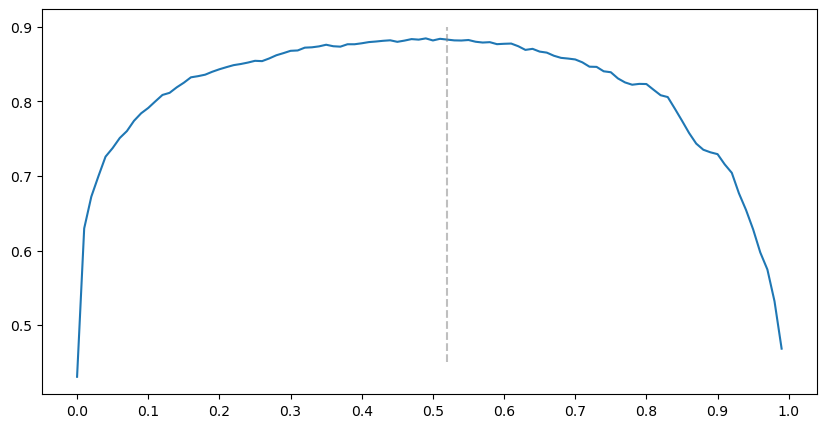

In [22]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.52, 0.45, 0.9, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()


#### Ans: 0.52

### Question 5: 5-Fold CV
###### Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:
###### KFold(n_splits=5, shuffle=True, random_state=1)
###### Iterate over different folds of df_full_train
###### Split the data into train and validation
###### Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
###### Use AUC to evaluate the model on validation

In [23]:
from sklearn.model_selection import KFold

In [24]:
columns = list(df.columns)
columns.remove('above_average')
columns

['make',
 'model',
 'year',
 'engine_hp',
 'engine_cylinders',
 'transmission_type',
 'vehicle_style',
 'highway_mpg',
 'city_mpg']

In [25]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [26]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.980 +- 0.004


#### Ans: 0.003

### Question 6: Hyperparemeter Tuning
###### Now let's use 5-Fold cross-validation to find the best parameter C

###### Iterate over the following C values: [0.01, 0.1, 0.5, 10]
###### Initialize KFold with the same parameters as previously
###### Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
###### Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [27]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 0.5, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.952 +- 0.002
C= 0.1, 0.971 +- 0.001
C= 0.5, 0.977 +- 0.002
C=  10, 0.981 +- 0.003


#### Ans: C=10 has the best mean score